# Introduction 

Dans ce fichier nous allons mettre en place une implémentation basique de l'algorithme proposé dans l'article à étudier.

Nous allons pour l'instant étudier le dataset Extended Yale B.

Les données sont présentes dans le dossier suivant : data/yale/

# Imports 

In [24]:
%matplotlib inline

In [25]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt

# Définition de fonctions utiles

In [2]:
def delta_i():
    '''
    fonction indicatrice de la classe i
    '''

In [3]:
def residu():
    '''
    renvoie le residu
    '''

In [4]:
def read_images(path, sz=None): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.NEAREST)     
                    X.append(np.asarray(im, dtype=np.uint8)) 
                    y.append(c)
                except IOError:
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
            print c
    return [X,y]

# Chargement des images 

In [5]:
X, y = read_images('data/CroppedYale', sz=(12,10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


Vérification qu'on a bien chargé les données des individus

In [6]:
len(X)

2470

Alright : on a bien chargé 585 images qui ont été fournies, par individu (note : les erreurs correspondent aux fichiers .info).

*Rappel* : 64 illuminations par personne.

## Réduction de dimensions 

La réduction de dimensions est déjà inclue dans le chargement des images.

De la même manière que dans l'article, nous réduisons la dimensions des images de ()

## Retraitement du dataset 

Nous allons dans un premier temps supprimer toutes les images "toutes noires" (premières images pour chaque individu.

In [7]:
X_new = []
y_new = []

for i in range(len(X)):
    if i%65!=0:
        X_new.append(X[i])
        y_new.append(y[i])

## Séparation du dataset en train et test 

A chaque personne sont associées 64 images stockées dans _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_Note :_ Une bonne partie des images est quasiment illisible (très mauvaise luminosité)

Afin d'avoir un test set et un train set à peu près homogènes, on va prendre 12 images de test pour 52 images de train (~19% dans le test), soit :

* 5 images "négatives"
* 7 images "positives"

In [8]:
X_train, X_test = [], []
ytrain, ytest = [], []

for i in range(len(X_new)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(28,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_new[i])
        ytest.append(y_new[i])
    else:
        X_train.append(X_new[i])
        ytrain.append(y_new[i])

## Manipulation des matrices

On déroule chaque image en un vecteur puis on les concatène.

In [9]:
X_toconcat_train = [np.reshape(e,(120,1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(120,1)) for e in X_test]

In [10]:
Xtrain = np.concatenate(X_toconcat_train,axis=1)
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

Vérification qu'on a la bonne taille

In [11]:
print('Taille du nouveau dataset',Xtest.shape)

('Taille du nouveau dataset', (120, 456))


C'est ok !

# Implémentation de l'algorithme 1 

In [12]:
from sklearn.linear_model import Lasso

On voit dans la littérature que cela revient à traiter le problème Lasso.

D'abord on crée un vecteur d'$\alpha_i$ à tester avec Lasso.

Puisqu'on utilise la fonction Lasso il est nécessaire d'adapter nos $\alpha_i$ à la dimension de $y$.

In [21]:
alpha_vec = np.logspace(2,3,10)
alpha_vec = alpha_vec/(Xtest.shape[0])

Puis on utilise Lasso pour trouver la solution à notre problème.

In [34]:
#for i, alpha in enumerate(alpha_vec):
clf = Lasso(alpha=alpha_vec[0]) #on prend l'alpha courant
clf.fit(Xtrain,Xtest[:,240])

Lasso(alpha=0.83333333333333337, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
clf.coef_

array([ 0.        , -0.        ,  0.15322046, ...,  0.        ,
       -0.        , -0.        ])

<Container object of 3 artists>

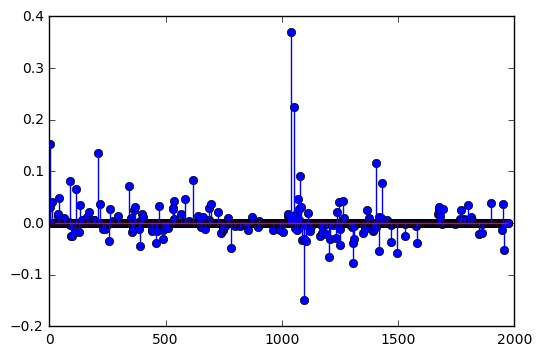

In [36]:
plt.figure()
plt.stem(clf.coef_)